In [2]:
!pip install metpy
!pip install netCDF4
!pip install siphon


  Using cached MetPy-0.12.2-py3-none-any.whl (319 kB)
  Using cached Pint-0.16.1-py2.py3-none-any.whl (205 kB)
  Using cached xarray-0.16.1-py3-none-any.whl (720 kB)
  Using cached pooch-1.2.0-py3-none-any.whl (47 kB)
  Using cached appdirs-1.4.4-py2.py3-none-any.whl (9.6 kB)
  Using cached netCDF4-1.5.4-cp38-cp38-manylinux1_x86_64.whl (4.3 MB)
  Using cached cftime-1.2.1-cp38-cp38-manylinux1_x86_64.whl (271 kB)
  Using cached siphon-0.8.0-py2.py3-none-any.whl (66 kB)


In [3]:
from datetime import datetime, timedelta

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import metpy.calc as mpcalc
import numpy as np

from metpy.plots import StationPlot
from metpy.units import units
from netCDF4 import Dataset, num2date
from scipy.ndimage import gaussian_filter
from siphon.catalog import TDSCatalog

In [29]:
from calendar import monthrange
from datetime import datetime
import itertools

from netCDF4 import date2num, num2date
import numpy as np
from pyproj import Proj
from siphon.catalog import TDSCatalog
import xarray as xr

base_catalog = 'http://www.esrl.noaa.gov/psd/thredds/catalog/Datasets/NARR/pressure/catalog.xml'
# base_catalog = 'http://www.esrl.noaa.gov/psd/thredds/catalog/Datasets/NARR/subsurface/catalog.xml'
base_catalog = 'http://www.esrl.noaa.gov/psd/thredds/catalog/Datasets/NARR/monolevel/catalog.xml'
main_cat = TDSCatalog(base_catalog)

# Spatial location to find stuff
points = [(69 , -135), (70, -134)]
lats, lons = map(np.array, zip(*points))
fields = ['ulwrf.ntat']
# fields = ['air.2m']#
fields = ['dswrf']

# for year, month, var in itertools.product(([2017]), range(6, 7),
#     dsname = '{}.{:4d}{:02d}.nc'.format(var, year, month)
# fields):

for year, var in itertools.product(([2017]),fields):
    # Figure out what to grab
    dsname = '{}.{:4d}.nc'.format(var, year)
    print('{}: downloading...'.format(dsname), end='')

    # Grab it using opendap--manually convert to CF to work around the
    # fact that missing_value and _FillValue differ
    ds = xr.open_dataset(main_cat.datasets[dsname].access_urls['OPENDAP'],
                         decode_cf=False)
    ds = xr.conventions.decode_cf(ds, mask_and_scale=False)

    # Grab the projection variable and convert our points to that
    # Probably not strictly necessary
#     if var == 'air.2m':
#         var = 'air'
#     if var == 'air.2m':
#         var = 'air'
    var = var.split('.')[0]
    proj_var = ds[ds[var].grid_mapping]
    proj = Proj(proj='lcc', lat_0=proj_var.latitude_of_projection_origin,
            lon_0=proj_var.longitude_of_central_meridian,
            lat_1=proj_var.standard_parallel[0],
lat_2=proj_var.standard_parallel[1],
            x_0=proj_var.false_easting, y_0=proj_var.false_northing,
ellps='sphere')
    x, y = proj(lons, lats)
    # Subset the data
    print('subsetting...', end='')
#     ds.
    pt_ds = ds.sel(x=x, y=y, method='nearest')
    print('saving...', end='')

    # Save to disk
    pt_ds.to_netcdf('Data/'+dsname)
    print('done.')

dswrf.2017.nc: downloading...subsetting...saving...done.


W/m^2
2.998972602739726


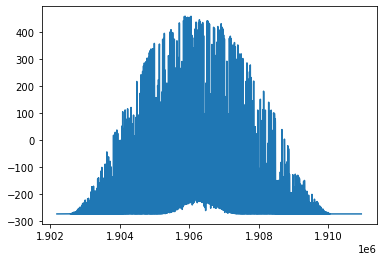

In [30]:
my_example_nc_file = 'Data/dswrf.2017.nc'
fh = Dataset(my_example_nc_file, mode='r')
time=fh.variables['time'][:]
# print(fh.variables)ulwrf
lons = fh.variables['lon'][:]
lats = fh.variables['lat'][:]
air = fh.variables['dswrf'][:]
# print(fh.variables['uwnd'].shape)
# print(fh.variables['uwnd'].shape)

# print(tmax[:,0,:,:].mean(axis=1).mean(axis=1).shape)

air = fh.variables['dswrf'][:]
print(fh.variables['dswrf'].units)
air_units = fh.variables['dswrf'].units
fh.close()

# print(time[-1]-time[0])
# print(lons)
plt.figure()
plt.plot(time,air[:,0,0]-273.15)
print((time.max()-time.min())/time.count())
